In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ctypes

from scipy.sparse import lil_matrix
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import NearestNeighbors
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

from matplotlib import style
%matplotlib inline
style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", color_codes=True)

# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

In [2]:
# Dataset Link: https://www.kaggle.com/datasets/rdoume/beerreviews
df = pd.read_csv("./dataset/beer_reviews_all.csv")
df.columns = ["breweryid", "brewery_name", "rating_time", "rating_overall", "rating_smell", "rating_look", "userid", "beer_style", "rating_feel", "rating_taste", "beer_name", "beer_abv", "beerid"]
df = df[["userid", "beerid", "rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_name", "beer_style", "brewery_name", "beer_abv", "breweryid", "rating_time"]]

df["beer_abv"].fillna(df["beer_abv"].mean(), inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.drop(index=df[df["rating_overall"].isin([0.0])].index, inplace=True)
df["beer_full"] = df["beer_name"] + " (" + df["beer_style"] + ") by " + df["brewery_name"]
df.reset_index(drop=True, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586244 entries, 0 to 1586243
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   userid          1586244 non-null  object 
 1   beerid          1586244 non-null  int64  
 2   rating_overall  1586244 non-null  float64
 3   rating_look     1586244 non-null  float64
 4   rating_smell    1586244 non-null  float64
 5   rating_taste    1586244 non-null  float64
 6   rating_feel     1586244 non-null  float64
 7   beer_name       1586244 non-null  object 
 8   beer_style      1586244 non-null  object 
 9   brewery_name    1586244 non-null  object 
 10  beer_abv        1586244 non-null  float64
 11  breweryid       1586244 non-null  int64  
 12  rating_time     1586244 non-null  int64  
 13  beer_full       1586244 non-null  object 
dtypes: float64(6), int64(3), object(5)
memory usage: 169.4+ MB


In [4]:
df.head()

,userid,beerid,rating_overall,rating_look,rating_smell,rating_taste,rating_feel,beer_name,beer_style,brewery_name,beer_abv,breweryid,rating_time,beer_full
0,stcules,47986,1.5,2.5,2.0,1.5,1.5,Sausa Weizen,Hefeweizen,Vecchio Birraio,5.0,10325,1234817823,Sausa Weizen (Hefeweizen) by Vecchio Birraio
1,stcules,48213,3.0,3.0,2.5,3.0,3.0,Red Moon,English Strong Ale,Vecchio Birraio,6.2,10325,1235915097,Red Moon (English Strong Ale) by Vecchio Birraio
2,stcules,48215,3.0,3.0,2.5,3.0,3.0,Black Horse Black Beer,Foreign / Export Stout,Vecchio Birraio,6.5,10325,1235916604,Black Horse Black Beer (Foreign / Export Stout...
3,stcules,47969,3.0,3.5,3.0,3.0,2.5,Sausa Pils,German Pilsener,Vecchio Birraio,5.0,10325,1234725145,Sausa Pils (German Pilsener) by Vecchio Birraio
4,johnmichaelsen,64883,4.0,4.0,4.5,4.5,4.0,Cauldron DIPA,American Double / Imperial IPA,Caldera Brewing Company,7.7,1075,1293735206,Cauldron DIPA (American Double / Imperial IPA)...


In [5]:
df[["rating_overall", "rating_look", "rating_smell", "rating_taste", "rating_feel", "beer_abv"]].describe().T

,count,mean,std,min,25%,50%,75%,max
rating_overall,1586244.0,3.815648,0.720549,1.00,3.5,4.0,4.5,5.0
rating_look,1586244.0,3.841694,0.616011,1.00,3.5,4.0,4.0,5.0
rating_smell,1586244.0,3.735693,0.697561,1.00,3.5,4.0,4.0,5.0
rating_taste,1586244.0,3.792932,0.731901,1.00,3.5,4.0,4.5,5.0
rating_feel,1586244.0,3.743762,0.682166,1.00,3.5,4.0,4.0,5.0
beer_abv,1586244.0,7.042497,2.272406,0.01,5.3,6.6,8.4,57.7


<Axes: xlabel='rating_overall'>

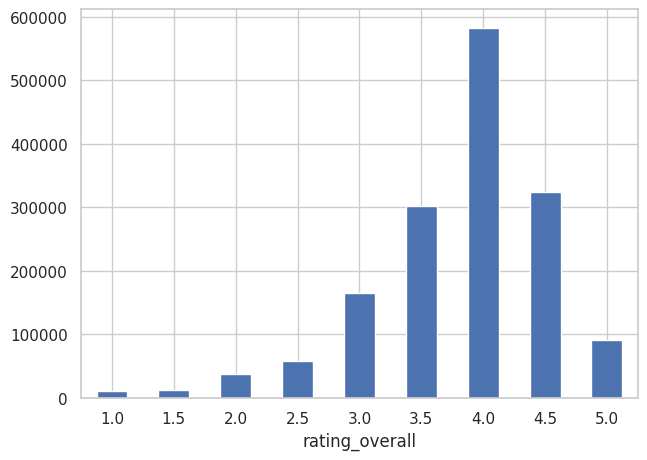

In [6]:
df["rating_overall"].value_counts().sort_index().plot(kind="bar", rot=0)

<Axes: >

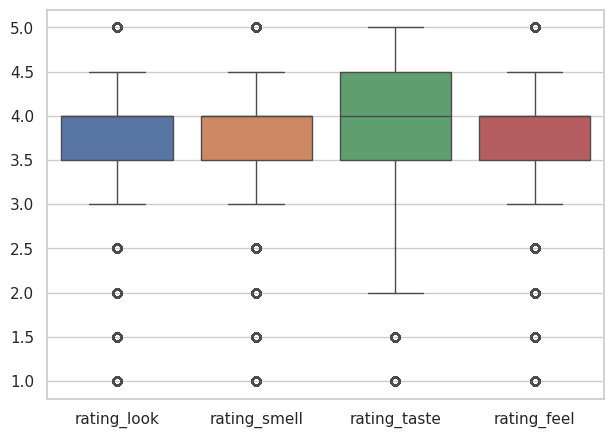

In [7]:
sns.boxplot(df[["rating_look", "rating_smell", "rating_taste", "rating_feel"]])

<Axes: xlabel='%ABV (Alcohol by volume)', ylabel='Frequency'>

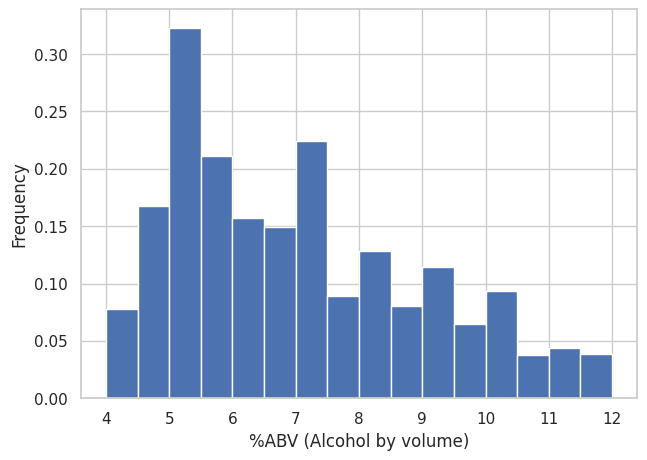

In [8]:
df["beer_abv"].plot(kind="hist", bins=16, range=[4, 12], density=True, xlabel="%ABV (Alcohol by volume)")

In [9]:
print("Most Popular Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beers


,mean,count
beer_full,,
90 Minute IPA (American Double / Imperial IPA) by Dogfish Head Brewery,4.145485,3289
Old Rasputin Russian Imperial Stout (Russian Imperial Stout) by North Coast Brewing Co.,4.174116,3110
Sierra Nevada Celebration Ale (American IPA) by Sierra Nevada Brewing Co.,4.168556,2999
"Two Hearted Ale (American IPA) by Bell's Brewery, Inc.",4.330216,2727
Stone Ruination IPA (American Double / Imperial IPA) by Stone Brewing Co.,4.161547,2702
Arrogant Bastard Ale (American Strong Ale) by Stone Brewing Co.,4.078090,2702
Sierra Nevada Pale Ale (American Pale Ale (APA)) by Sierra Nevada Brewing Co.,4.245845,2587
Stone IPA (India Pale Ale) (American IPA) by Stone Brewing Co.,4.257576,2574
Pliny The Elder (American Double / Imperial IPA) by Russian River Brewing Company,4.590028,2527


In [10]:
print("Best Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean", ascending=False).head(10)

Best Rated Beers


,mean,count
beer_full,,
Citra DIPA (American Double / Imperial IPA) by Kern River Brewing Company,4.630952,252
Cantillon Blåbær Lambik (Lambic - Fruit) by Brasserie Cantillon,4.628205,156
Heady Topper (American Double / Imperial IPA) by The Alchemist,4.625800,469
Deviation - Bottleworks 9th Anniversary (American Wild Ale) by Russian River Brewing Company,4.620536,112
Trappist Westvleteren 12 (Quadrupel (Quad)) by Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren),4.617925,1272
Pliny The Younger (American Double / Imperial IPA) by Russian River Brewing Company,4.600000,610
Founders CBS Imperial Stout (American Double / Imperial Stout) by Founders Brewing Company,4.591052,637
Pliny The Elder (American Double / Imperial IPA) by Russian River Brewing Company,4.590028,2527
Live Oak HefeWeizen (Hefeweizen) by Live Oak Brewing Company,4.562112,322


In [11]:
print("Worst Rated Beers")
df.groupby("beer_full").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).loc[lambda x: x["count"]>=100].sort_values("mean").head(10)

Worst Rated Beers


,mean,count
beer_full,,
Crazy Ed's Cave Creek Chili Beer (Chile Beer) by Chili Beer Co.,1.488764,267
Original C Cave Creek Chili Beer - Cerveza Con Chili (Chile Beer) by Chili Beer Co.,1.681818,132
Bud Light Chelada (Fruit / Vegetable Beer) by Anheuser-Busch,1.710526,114
Wild Blue (Blueberry Lager) (Fruit / Vegetable Beer) by Anheuser-Busch,1.924116,481
Budweiser Chelada (Fruit / Vegetable Beer) by Anheuser-Busch,1.931159,138
Bud Extra (Herbed / Spiced Beer) by Anheuser-Busch,1.953125,128
Corona Light (Light Lager) by Grupo Modelo S.A. de C.V.,1.957602,342
Brewer Patriot Collection - 1790 Root Beer Brew (Herbed / Spiced Beer) by Boston Beer Company (Samuel Adams),2.089286,196
Michelob Ultra (Light Lager) by Anheuser-Busch,2.159962,522


In [12]:
print("Most Popular Beer Styles")
df.groupby("beer_style").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Beer Styles


,mean,count
beer_style,,
American IPA,3.965207,117566
American Double / Imperial IPA,3.997987,85958
American Pale Ale (APA),3.852432,63459
Russian Imperial Stout,4.023041,54120
American Double / Imperial Stout,4.029746,50696
American Porter,3.895707,50473
American Amber / Red Ale,3.781128,45739
Belgian Strong Dark Ale,3.913334,37731
Fruit / Vegetable Beer,3.415192,33859


In [13]:
print("Most Popular Breweries")
df.groupby("brewery_name").agg(
    mean=("rating_overall", "mean"),
    count=("rating_overall", "count")
    ).sort_values("count", ascending=False).head(10)

Most Popular Breweries


,mean,count
brewery_name,,
Boston Beer Company (Samuel Adams),3.689563,39438
Dogfish Head Brewery,3.836013,33829
Stone Brewing Co.,4.040193,33053
Sierra Nevada Brewing Co.,4.056182,28746
"Bell's Brewery, Inc.",3.973064,25189
Rogue Ales,3.908842,24079
Founders Brewing Company,4.114475,20000
Victory Brewing Company,3.996328,19473
Lagunitas Brewing Company,3.955769,16832


In [14]:
rating, min_quality, min_quantity = "rating_overall", 3, 10
l1_reg, l2_reg = 0.001, 0.0001
threads = max(1, mp.cpu_count()-2)
N = 10

df = df[["userid", "beerid", rating, "beer_full"]]
df = df[df[rating] >= min_quality]
df_temp = df["userid"].value_counts()
df = df[df["userid"].isin(df_temp[df_temp >= min_quantity].index)]
df_temp = df["beerid"].value_counts()
df = df[df["beerid"].isin(df_temp[df_temp >= min_quantity].index)]
df.reset_index(drop=True, inplace=True)
U, T = np.sort(df["userid"].unique()), np.sort(df["beerid"].unique())
m, n = len(U), len(T)
df["userid"] = df["userid"].map({userid: index for index, userid in enumerate(U)})
df["beerid"] = df["beerid"].map({beerid: index for index, beerid in enumerate(T)})

model = ElasticNet(alpha=l1_reg+l2_reg,
                   l1_ratio=l1_reg/(l1_reg+l2_reg),
                   positive=True, fit_intercept=False, copy_X=False)
model_knn = NearestNeighbors(n_neighbors=int(n/10))

In [15]:
def get_train_test(df):
    test = df.groupby("userid", group_keys=False).apply(lambda grp: grp.sample(n=1))
    train = df.drop(test.index)
    return train, test

In [16]:
def get_A(train):
    A = lil_matrix((m, n))
    for row in zip(train["userid"], train["beerid"], train[rating]):
        A[row[0], row[1]] = row[2]
    return A

In [17]:
def get_A_hat(A):
    m, n = A.shape
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [18]:
def parallel(params):
    A = params[2]
    for j in range(params[0], params[1]):
        a_j = A[:, j].copy()
        A[:, j] = 0
        model.fit(A, a_j.toarray())
        A[:, j] = a_j
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W_[(index, j)] = w_j[index]

def get_A_hat_parallel(A):
    m, n = A.shape
    global W_
    W_ = np.ctypeslib.as_array(
        mp.Array(ctypes.c_double, n*n).get_obj()
        ).reshape(n, n)
    n_ = math.ceil(n/threads)
    params = []
    for i in range(threads-1):
        params.append([i*n_, (i+1)*n_, A])
    params.append([(i+1)*n_, n, A])
    with ProcessPoolExecutor() as executor:
        executor.map(parallel, params)
    return lil_matrix(A @ W_)

In [19]:
def get_A_hat_fs(A):
    m, n = A.shape
    A_csc = A.tocsc(copy=True)
    model_knn.fit(A.transpose(copy=True))
    nn = model_knn.kneighbors(return_distance=False)
    W = lil_matrix((n, n))
    for j in range(n):
        a_j = A[:, j].copy()
        model.fit(A_csc[:, nn[j]], a_j.toarray())
        w_j = model.coef_
        w_j[w_j < 0] = 0
        for index in w_j.nonzero()[0]:
            W[(index, j)] = w_j[index]
    return (A @ W).tolil()

In [20]:
def get_recs(A_hat, A):
    m, n = A_hat.shape
    recs = []
    for i in range(m):
        recs.append([])
        for j in A_hat[i].nonzero()[1]:
            if (A[(i, j)] == 0):
                recs[-1].append((j, A_hat[(i, j)]))
        recs[-1].sort(key=lambda x: x[1], reverse=True)
        recs[-1] = [pair[0] for pair in recs[-1][:N]]
    return recs

In [21]:
def display_user_recs(df, recs, userid):
    print(f"Top {N} Beer Recommendations for User#{userid}\n")
    for rec in recs[userid]:
        print(df[df["beerid"] == rec]["beer_full"].tolist()[0])

In [22]:
def get_HR_ARHR(recs, test):
    test.reset_index(drop=True, inplace=True)
    HR, ARHR = 0, 0
    for i in range(m):
        try:
            p = recs[i].index(test["beerid"][i]) + 1
            HR += 1
            ARHR += (1 / p)
        except ValueError:
            continue
    return (HR/m, ARHR/m)

In [23]:
train, test = get_train_test(df)
A = get_A(train)

In [24]:
A_hat = get_A_hat(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.29740661432310256
Average Reciprocal Hit-Rank (ARHR): 0.13777866527688062


In [25]:
A_hat = get_A_hat_parallel(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.29740661432310256
Average Reciprocal Hit-Rank (ARHR): 0.13777866527688062


In [26]:
A_hat = get_A_hat_fs(A)
recs = get_recs(A_hat, A)
HR, ARHR = get_HR_ARHR(recs, test)
print(f"Hit Rate (HR): {HR}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR}")

Hit Rate (HR): 0.025220080894599095
Average Reciprocal Hit-Rank (ARHR): 0.008798703873650343


In [27]:
HR_avg, ARHR_avg = [0.0, 0.0]
for i in range(5):
  train, test = get_train_test(df)
  A = get_A(train)
  A_hat = get_A_hat_parallel(A)
  recs = get_recs(A_hat, A)
  HR, ARHR = get_HR_ARHR(recs, test)
  HR_avg += HR
  ARHR_avg += ARHR
HR_avg /= 5
ARHR_avg /= 5
print(f"Hit Rate (HR): {HR_avg}\nAverage Reciprocal Hit-Rank (ARHR): {ARHR_avg}")

Hit Rate (HR): 0.30563882940756604
Average Reciprocal Hit-Rank (ARHR): 0.13807850779299752
